In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 640.4847, train_label_loss: 2.7842, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 10609.1649, train_label_loss: 2.6928, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 10679.6641, train_label_loss: 2.5385, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 10749.9834, train_label_loss: 2.4882, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 10734.7300, train_label_loss: 2.3535, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 10695.6502, train_label_loss: 2.1767, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 10729.2257, train_label_loss: 2.0464, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 10724.5779, train_label_loss: 1.8494, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 10635.1401, train_label_loss: 1.7225, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 10656.9476, train_label_loss: 1.5277, 


epoch: 1, source_val_acc_label: 0.6068, source_val_label_loss: 1.4541, target_val_acc_label: 0.6068, target_val_label_loss: 1.4541, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 48.8281, train_label_loss: 1.4054, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 10487.4620, train_label_loss: 1.3586, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 10597.5712, train_label_loss: 1.1903, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 10635.0498, train_label_loss: 1.3894, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 10604.7543, train_label_loss: 1.0540, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 10627.2441, train_label_loss: 0.9069, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 10697.5820, train_label_loss: 1.2140, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 10535.3163, train_label_loss: 0.8390, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 10650.8180, train_label_loss: 0.7149, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 10649.2893, train_label_loss: 0.7443, 


epoch: 2, source_val_acc_label: 0.8495, source_val_label_loss: 0.6134, target_val_acc_label: 0.8495, target_val_label_loss: 0.6134, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 56.6594, train_label_loss: 0.7328, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 10499.0771, train_label_loss: 0.6351, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 10607.2057, train_label_loss: 1.0078, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 10666.7480, train_label_loss: 0.4803, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 10634.8075, train_label_loss: 0.4985, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 10685.9213, train_label_loss: 0.5520, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 10632.8412, train_label_loss: 0.5405, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 10672.0837, train_label_loss: 0.4272, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 10690.2103, train_label_loss: 0.4702, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 10578.5019, train_label_loss: 0.4758, 


epoch: 3, source_val_acc_label: 0.9163, source_val_label_loss: 0.4116, target_val_acc_label: 0.9163, target_val_label_loss: 0.4116, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 56.4942, train_label_loss: 0.2820, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 10626.9424, train_label_loss: 0.3968, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 10669.7401, train_label_loss: 0.3952, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 10620.1640, train_label_loss: 0.3188, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 10613.1594, train_label_loss: 0.3126, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 10581.9930, train_label_loss: 0.3707, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 10603.2194, train_label_loss: 0.2743, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 10612.0205, train_label_loss: 0.2897, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 10565.4891, train_label_loss: 0.3473, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 10526.8688, train_label_loss: 0.3960, 


epoch: 4, source_val_acc_label: 0.9356, source_val_label_loss: 0.2770, target_val_acc_label: 0.9356, target_val_label_loss: 0.2770, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 57.1814, train_label_loss: 0.3189, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 10619.1152, train_label_loss: 0.2609, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 10643.8919, train_label_loss: 0.2817, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 10612.8567, train_label_loss: 0.2754, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 10597.1065, train_label_loss: 0.2525, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 10676.3571, train_label_loss: 0.2718, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 10621.9786, train_label_loss: 0.1864, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 10684.9035, train_label_loss: 0.2776, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 10671.3928, train_label_loss: 0.3077, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 10691.8998, train_label_loss: 0.2253, 


epoch: 5, source_val_acc_label: 0.9311, source_val_label_loss: 0.2764, target_val_acc_label: 0.9311, target_val_label_loss: 0.2764, 


epoch: 6, [batch: 1 / 1400], examples_per_second: 57.4950, train_label_loss: 0.2243, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 10583.4106, train_label_loss: 0.2253, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 10650.0558, train_label_loss: 0.2664, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 10630.8982, train_label_loss: 0.2452, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 10683.4591, train_label_loss: 0.1873, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 10662.8741, train_label_loss: 0.2809, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 10579.0737, train_label_loss: 0.2743, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 10599.6306, train_label_loss: 0.1916, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 10656.0698, train_label_loss: 0.2468, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 10588.5269, train_label_loss: 0.1624, 


epoch: 6, source_val_acc_label: 0.9308, source_val_label_loss: 0.2870, target_val_acc_label: 0.9308, target_val_label_loss: 0.2870, 


epoch: 7, [batch: 1 / 1400], examples_per_second: 57.0867, train_label_loss: 0.3154, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 10675.3232, train_label_loss: 0.1717, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 10684.8078, train_label_loss: 0.2245, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 10670.2611, train_label_loss: 0.1857, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 10607.0440, train_label_loss: 0.1623, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 10358.7997, train_label_loss: 0.2470, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 10681.4900, train_label_loss: 0.1946, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 10708.3191, train_label_loss: 0.1793, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 10677.5492, train_label_loss: 0.2407, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 10677.1427, train_label_loss: 0.2081, 


epoch: 7, source_val_acc_label: 0.9506, source_val_label_loss: 0.2740, target_val_acc_label: 0.9506, target_val_label_loss: 0.2740, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 56.2697, train_label_loss: 0.1824, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 10614.9492, train_label_loss: 0.1708, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 10578.8221, train_label_loss: 0.1105, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 10674.0070, train_label_loss: 0.1813, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 10655.4096, train_label_loss: 0.1591, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 10638.6550, train_label_loss: 0.3167, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 10643.6567, train_label_loss: 0.1444, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 10656.7527, train_label_loss: 0.1615, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 10641.0574, train_label_loss: 0.2022, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 10640.3946, train_label_loss: 0.1760, 


epoch: 8, source_val_acc_label: 0.9473, source_val_label_loss: 0.2054, target_val_acc_label: 0.9473, target_val_label_loss: 0.2054, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 56.3765, train_label_loss: 0.1829, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 10607.6312, train_label_loss: 0.1449, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 10642.3803, train_label_loss: 0.1540, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 10614.4588, train_label_loss: 0.1257, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 10661.2437, train_label_loss: 0.1317, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 10531.6804, train_label_loss: 0.1887, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 10701.7813, train_label_loss: 0.1134, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 10833.1555, train_label_loss: 0.0992, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 10653.8283, train_label_loss: 0.1965, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 10685.0614, train_label_loss: 0.1826, 


epoch: 9, source_val_acc_label: 0.9586, source_val_label_loss: 0.1688, target_val_acc_label: 0.9586, target_val_label_loss: 0.1688, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 56.6082, train_label_loss: 0.0984, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 10605.4800, train_label_loss: 0.1159, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 10631.1929, train_label_loss: 0.1243, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 10666.1395, train_label_loss: 0.0846, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 10634.3351, train_label_loss: 0.1236, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 10594.4208, train_label_loss: 0.0961, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 10627.2877, train_label_loss: 0.1757, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 10644.3139, train_label_loss: 0.0987, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 10618.8272, train_label_loss: 0.0939, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 10721.9358, train_label_loss: 0.2071, 


epoch: 10, source_val_acc_label: 0.9576, source_val_label_loss: 0.1667, target_val_acc_label: 0.9576, target_val_label_loss: 0.1667, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 56.7681, train_label_loss: 0.1147, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 10642.0502, train_label_loss: 0.1012, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 10641.7203, train_label_loss: 0.1257, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 10710.9194, train_label_loss: 0.1241, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 10695.9896, train_label_loss: 0.1708, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 10567.5123, train_label_loss: 0.1128, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 10687.0563, train_label_loss: 0.1471, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 10717.0253, train_label_loss: 0.0778, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 10680.9420, train_label_loss: 0.2131, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 10710.8767, train_label_loss: 0.2303, 


epoch: 11, source_val_acc_label: 0.9577, source_val_label_loss: 0.1335, target_val_acc_label: 0.9577, target_val_label_loss: 0.1335, 


epoch: 12, [batch: 1 / 1400], examples_per_second: 57.6417, train_label_loss: 0.1060, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 10627.0362, train_label_loss: 0.0807, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 10671.9065, train_label_loss: 0.1762, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 10627.1314, train_label_loss: 0.0731, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 10650.4618, train_label_loss: 0.1258, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 10655.3900, train_label_loss: 0.0679, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 10841.8094, train_label_loss: 0.0959, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 10691.8420, train_label_loss: 0.1123, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 10648.2619, train_label_loss: 0.1192, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 10677.3930, train_label_loss: 0.1190, 


epoch: 12, source_val_acc_label: 0.9538, source_val_label_loss: 0.1864, target_val_acc_label: 0.9538, target_val_label_loss: 0.1864, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 57.4109, train_label_loss: 0.0586, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 10602.9153, train_label_loss: 0.1609, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 10702.6545, train_label_loss: 0.1099, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 10677.7646, train_label_loss: 0.1004, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 10623.4424, train_label_loss: 0.0952, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 10655.3583, train_label_loss: 0.1265, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 10730.9766, train_label_loss: 0.1216, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 10630.6846, train_label_loss: 0.1498, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 10636.7144, train_label_loss: 0.1210, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 10677.9542, train_label_loss: 0.1697, 


epoch: 13, source_val_acc_label: 0.9645, source_val_label_loss: 0.1317, target_val_acc_label: 0.9645, target_val_label_loss: 0.1317, 


New best
epoch: 14, [batch: 1 / 1400], examples_per_second: 56.7952, train_label_loss: 0.0932, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 10578.3488, train_label_loss: 0.0518, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 10684.1258, train_label_loss: 0.1280, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 10645.1672, train_label_loss: 0.0559, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 10703.2992, train_label_loss: 0.0736, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 10570.2483, train_label_loss: 0.0764, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 10669.4750, train_label_loss: 0.0984, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 10710.9973, train_label_loss: 0.0767, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 10710.9286, train_label_loss: 0.0739, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 10612.1899, train_label_loss: 0.1052, 


epoch: 14, source_val_acc_label: 0.9616, source_val_label_loss: 0.1212, target_val_acc_label: 0.9616, target_val_label_loss: 0.1212, 


epoch: 15, [batch: 1 / 1400], examples_per_second: 57.9132, train_label_loss: 0.0722, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 10664.3909, train_label_loss: 0.1145, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 10699.6134, train_label_loss: 0.1022, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 10623.4844, train_label_loss: 0.0908, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10693.0512, train_label_loss: 0.0919, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10706.0251, train_label_loss: 0.3221, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10695.9668, train_label_loss: 0.0774, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10695.9394, train_label_loss: 0.0747, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10715.2728, train_label_loss: 0.1352, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10714.7581, train_label_loss: 0.1168, 


epoch: 15, source_val_acc_label: 0.9616, source_val_label_loss: 0.3001, target_val_acc_label: 0.9616, target_val_label_loss: 0.3001, 


epoch: 16, [batch: 1 / 1400], examples_per_second: 56.4069, train_label_loss: 0.0616, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 10703.6762, train_label_loss: 0.0863, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 10647.0521, train_label_loss: 0.1751, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 10707.3017, train_label_loss: 0.0918, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 10637.2337, train_label_loss: 0.0820, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 10741.6290, train_label_loss: 0.1540, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 10686.2236, train_label_loss: 0.0486, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 10744.5234, train_label_loss: 0.0474, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 10600.3512, train_label_loss: 0.1069, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 10701.7813, train_label_loss: 0.0793, 


epoch: 16, source_val_acc_label: 0.9649, source_val_label_loss: 0.2464, target_val_acc_label: 0.9649, target_val_label_loss: 0.2464, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 57.0849, train_label_loss: 0.1079, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 10599.6864, train_label_loss: 0.0974, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 10696.9699, train_label_loss: 0.1041, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 10687.2052, train_label_loss: 0.1023, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 10707.8035, train_label_loss: 0.0882, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 10696.9288, train_label_loss: 0.0718, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 10660.3818, train_label_loss: 0.0797, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 10712.8018, train_label_loss: 0.0543, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 10728.9684, train_label_loss: 0.0774, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 10752.5378, train_label_loss: 0.0569, 


epoch: 17, source_val_acc_label: 0.9668, source_val_label_loss: 0.2296, target_val_acc_label: 0.9668, target_val_label_loss: 0.2296, 


New best
epoch: 18, [batch: 1 / 1400], examples_per_second: 56.6862, train_label_loss: 0.1215, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 10652.5929, train_label_loss: 0.0682, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 10738.1285, train_label_loss: 0.1404, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 10689.0062, train_label_loss: 0.0804, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 10670.0385, train_label_loss: 0.0886, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 10658.9471, train_label_loss: 0.0864, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 10732.6943, train_label_loss: 0.0849, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 10724.8916, train_label_loss: 0.0732, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 10723.2819, train_label_loss: 0.1166, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 10606.6743, train_label_loss: 0.0631, 


epoch: 18, source_val_acc_label: 0.9603, source_val_label_loss: 0.1456, target_val_acc_label: 0.9603, target_val_label_loss: 0.1456, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 56.4798, train_label_loss: 0.0432, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 10687.5129, train_label_loss: 0.0687, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 10661.0047, train_label_loss: 0.0590, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 10829.2316, train_label_loss: 0.0919, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 10729.3972, train_label_loss: 0.0639, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 10687.4118, train_label_loss: 0.1722, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 10704.3388, train_label_loss: 0.0679, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 10688.6672, train_label_loss: 0.0393, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 10689.6629, train_label_loss: 0.0784, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 10727.2764, train_label_loss: 0.3035, 


epoch: 19, source_val_acc_label: 0.9491, source_val_label_loss: 0.1978, target_val_acc_label: 0.9491, target_val_label_loss: 0.1978, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 56.1333, train_label_loss: 0.0950, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 10602.5056, train_label_loss: 0.0538, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 10693.0665, train_label_loss: 0.0514, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 10652.8076, train_label_loss: 0.0533, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 10697.9961, train_label_loss: 0.1108, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 10699.0591, train_label_loss: 0.1148, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 10687.0958, train_label_loss: 0.0713, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 10741.1777, train_label_loss: 0.0512, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 10653.6093, train_label_loss: 0.0475, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 10756.6019, train_label_loss: 0.0315, 


epoch: 20, source_val_acc_label: 0.9661, source_val_label_loss: 0.1338, target_val_acc_label: 0.9661, target_val_label_loss: 0.1338, 


epoch: 21, [batch: 1 / 1400], examples_per_second: 57.7611, train_label_loss: 0.0667, 


epoch: 21, [batch: 140 / 1400], examples_per_second: 10660.6280, train_label_loss: 0.0207, 


epoch: 21, [batch: 280 / 1400], examples_per_second: 10493.0896, train_label_loss: 0.0873, 


epoch: 21, [batch: 420 / 1400], examples_per_second: 10510.2409, train_label_loss: 0.0719, 


epoch: 21, [batch: 560 / 1400], examples_per_second: 10616.1035, train_label_loss: 0.0986, 


epoch: 21, [batch: 700 / 1400], examples_per_second: 10684.7349, train_label_loss: 0.0359, 


epoch: 21, [batch: 840 / 1400], examples_per_second: 10649.6620, train_label_loss: 0.1189, 


epoch: 21, [batch: 980 / 1400], examples_per_second: 10665.2889, train_label_loss: 0.0480, 


epoch: 21, [batch: 1120 / 1400], examples_per_second: 10560.2059, train_label_loss: 0.0613, 


epoch: 21, [batch: 1260 / 1400], examples_per_second: 10684.3962, train_label_loss: 0.0488, 


epoch: 21, source_val_acc_label: 0.9688, source_val_label_loss: 0.2247, target_val_acc_label: 0.9688, target_val_label_loss: 0.2247, 


New best
epoch: 22, [batch: 1 / 1400], examples_per_second: 57.7400, train_label_loss: 0.0438, 


epoch: 22, [batch: 140 / 1400], examples_per_second: 10610.1499, train_label_loss: 0.0777, 


epoch: 22, [batch: 280 / 1400], examples_per_second: 11298.7040, train_label_loss: 0.0680, 


epoch: 22, [batch: 420 / 1400], examples_per_second: 11777.7245, train_label_loss: 0.1740, 


epoch: 22, [batch: 560 / 1400], examples_per_second: 11780.9754, train_label_loss: 0.1036, 


epoch: 22, [batch: 700 / 1400], examples_per_second: 11698.5548, train_label_loss: 0.0683, 


epoch: 22, [batch: 840 / 1400], examples_per_second: 11722.5147, train_label_loss: 0.0874, 


epoch: 22, [batch: 980 / 1400], examples_per_second: 11745.4588, train_label_loss: 0.0424, 


epoch: 22, [batch: 1120 / 1400], examples_per_second: 11691.5979, train_label_loss: 0.0263, 


epoch: 22, [batch: 1260 / 1400], examples_per_second: 11746.6428, train_label_loss: 0.0364, 


epoch: 22, source_val_acc_label: 0.9596, source_val_label_loss: 0.1468, target_val_acc_label: 0.9596, target_val_label_loss: 0.1468, 


epoch: 23, [batch: 1 / 1400], examples_per_second: 65.5555, train_label_loss: 0.0502, 


epoch: 23, [batch: 140 / 1400], examples_per_second: 11659.3563, train_label_loss: 0.0711, 


epoch: 23, [batch: 280 / 1400], examples_per_second: 11778.4498, train_label_loss: 0.0411, 


epoch: 23, [batch: 420 / 1400], examples_per_second: 11709.7198, train_label_loss: 0.0630, 


epoch: 23, [batch: 560 / 1400], examples_per_second: 11741.2975, train_label_loss: 0.0890, 


epoch: 23, [batch: 700 / 1400], examples_per_second: 11677.3643, train_label_loss: 0.0498, 


epoch: 23, [batch: 840 / 1400], examples_per_second: 11785.3848, train_label_loss: 0.0587, 


epoch: 23, [batch: 980 / 1400], examples_per_second: 11779.7198, train_label_loss: 0.0858, 


epoch: 23, [batch: 1120 / 1400], examples_per_second: 11729.6201, train_label_loss: 0.1671, 


epoch: 23, [batch: 1260 / 1400], examples_per_second: 11596.1174, train_label_loss: 0.1044, 


epoch: 23, source_val_acc_label: 0.9679, source_val_label_loss: 0.1534, target_val_acc_label: 0.9679, target_val_label_loss: 0.1534, 


epoch: 24, [batch: 1 / 1400], examples_per_second: 65.0312, train_label_loss: 0.0578, 


epoch: 24, [batch: 140 / 1400], examples_per_second: 11690.8738, train_label_loss: 0.0957, 


epoch: 24, [batch: 280 / 1400], examples_per_second: 11788.4328, train_label_loss: 0.0262, 


epoch: 24, [batch: 420 / 1400], examples_per_second: 11741.1104, train_label_loss: 0.0482, 


epoch: 24, [batch: 560 / 1400], examples_per_second: 11785.8024, train_label_loss: 0.0471, 


epoch: 24, [batch: 700 / 1400], examples_per_second: 11703.7719, train_label_loss: 0.0281, 


epoch: 24, [batch: 840 / 1400], examples_per_second: 11650.5230, train_label_loss: 0.0628, 


epoch: 24, [batch: 980 / 1400], examples_per_second: 11714.9724, train_label_loss: 0.0404, 


epoch: 24, [batch: 1120 / 1400], examples_per_second: 11737.7862, train_label_loss: 0.0467, 


epoch: 24, [batch: 1260 / 1400], examples_per_second: 11786.8411, train_label_loss: 0.0585, 


epoch: 24, source_val_acc_label: 0.9667, source_val_label_loss: 0.2376, target_val_acc_label: 0.9667, target_val_label_loss: 0.2376, 


epoch: 25, [batch: 1 / 1400], examples_per_second: 65.0936, train_label_loss: 0.0362, 


epoch: 25, [batch: 140 / 1400], examples_per_second: 11678.6722, train_label_loss: 0.0561, 


epoch: 25, [batch: 280 / 1400], examples_per_second: 11767.1221, train_label_loss: 0.0429, 


epoch: 25, [batch: 420 / 1400], examples_per_second: 11793.4658, train_label_loss: 0.0454, 


epoch: 25, [batch: 560 / 1400], examples_per_second: 11719.3728, train_label_loss: 0.0509, 


epoch: 25, [batch: 700 / 1400], examples_per_second: 11678.5165, train_label_loss: 0.0541, 


epoch: 25, [batch: 840 / 1400], examples_per_second: 11751.0100, train_label_loss: 0.0372, 


epoch: 25, [batch: 980 / 1400], examples_per_second: 11744.1466, train_label_loss: 0.0403, 


epoch: 25, [batch: 1120 / 1400], examples_per_second: 11775.6855, train_label_loss: 0.0561, 


epoch: 25, [batch: 1260 / 1400], examples_per_second: 11720.0050, train_label_loss: 0.0501, 


epoch: 25, source_val_acc_label: 0.9676, source_val_label_loss: 0.2992, target_val_acc_label: 0.9676, target_val_label_loss: 0.2992, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

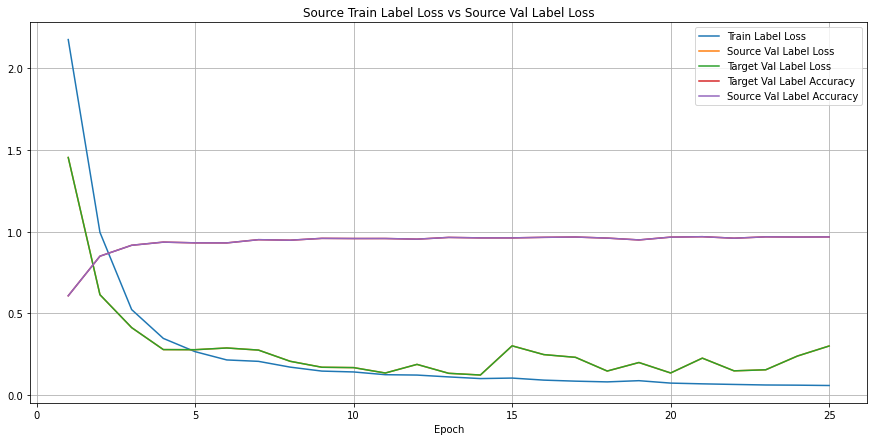

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

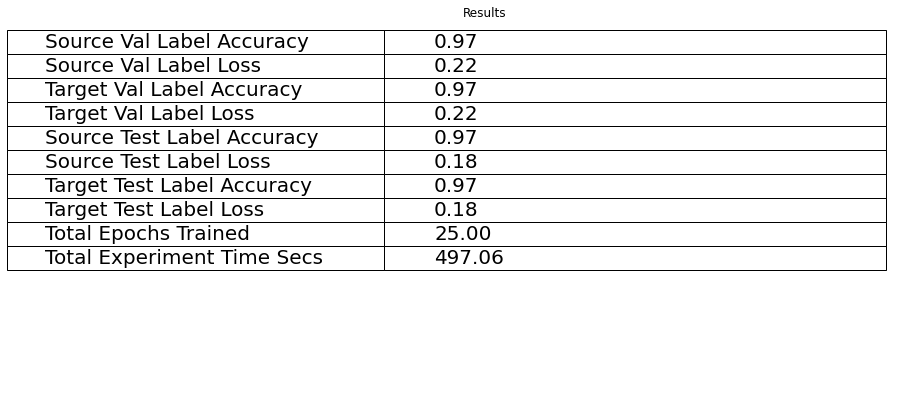

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

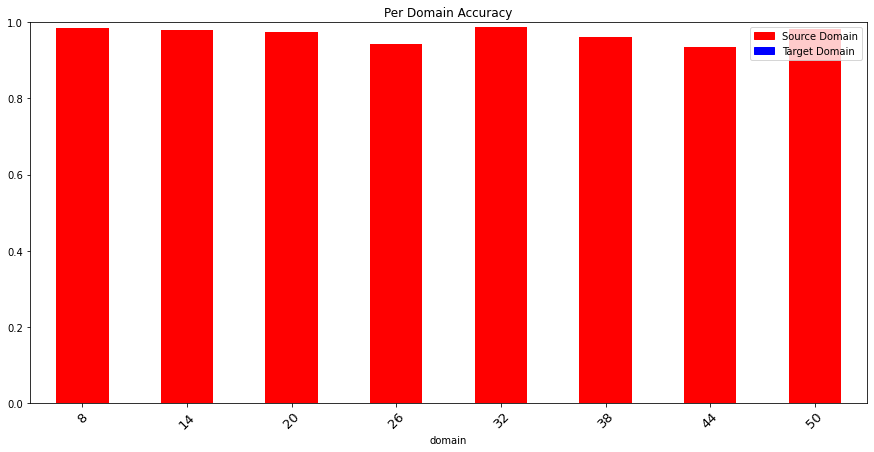

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9702864583333334 Target Test Label Accuracy: 0.9702864583333334
Source Val Label Accuracy: 0.968828125 Target Val Label Accuracy: 0.968828125


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2.framed", "parameters": {"experiment_name": "cnn_2:oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch